# (N)on-(E)uclidean (U)pgrading
---
#### Description of NEU:
The NEU meta-algorithm learns a geometry for the input and (input $\times$ output) spaces by deforming them with a universal class of homeomorphisms + robustifies the involved loss functions to improve generalizability of the new and very flexible model.  
$$
\begin{aligned}
f \mapsto& \, \rho \circ f \circ \phi\\
\mathbb{E}_{\mathbb{P}}[\ell(f(X))] \mapsto & \,\max_{\mathbb{Q}\sim \mathbb{P}}\, \mathbb{E}_{\mathbb{Q}}[\ell(\rho(\phi(X), f\circ \phi(X)))].
\end{aligned}
$$
$\rho=\pi\circ \tilde{\rho}$, and $\tilde{\rho}$ and $\phi$ are "universal homeomorphisms" on $\operatorname{dom}(f)$ and on $\operatorname{dom}(f)\times \operatorname{co-dom}(f)$, respectively.  

---

---

#### Description of regression problem: 
In this notebook we implement the regression problem
$$
\begin{aligned}
y_i =&  \,f(x_i)\delta_i + \epsilon_i, \qquad i=1,\dots,N\\
\epsilon_i \sim &\, \mathcal{N}(0,\sigma),\\
\delta_i\sim &  \,U(1-D,1+D),
\end{aligned}
$$
for some *variance* $\sigma>0$ and *degree of model misspecification level* $0<D<1$.  
The quantity $\epsilon$ can be understood as, classical, additive noise while the quantity $\delta$ represents multiplicative noise.

---

---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
#---------------------------------#
# General Formatting Parameter(s) #
#---------------------------------#
d = 1 # Dimension of X
D = 1 # Dimension of Y

#------------------------------------#
# Training/Optimization Parameter(s) #
#------------------------------------#
# Robustness Parameter
robustness_parameter = .05
# Training meta-parameters
Pre_Epochs = 200
Full_Epochs = 600

#---------------------------#
# Architecture Parameter(s) #
#---------------------------#
# 1) Base Model
#---------------#
Initial_Depth = 2
Initial_Height = 50
# 2) Feature Map
#---------------#
Feature_map_depth = 100
Feature_map_height = 20
# 3) Readout Map
#---------------#
# Reconfiguration Parameters
N_Reconfigurations = 100
# Depth & Height Per Reconfiguration
Depth_per_reconfig = 50
Height_per_reconfig = 20

#-------------------#
# Data Parameter(s) #
#-------------------#
# Test-set meta-parameters
Train_step_proportion = .75 # (i.e.: ratio of train to test-set sizes)
Extrapolation_size = .25 # (i.e.: size of test-train set domain (diameter/2))
# Train Data meta-parameters
N_data = 10**3 # (i.e.: N)
# Noise Parameters
noise_level = .5 # (i.e.: ε_i)
Distortion = .5 # (i.e.: δ_i)
# Unknown Function:
def unknown_f(x):
    return .1*x*np.sin(x) + (x**2)*np.cos(x) + x*np.exp(-np.abs(x)) + np.sin(4*x + 3*x**2) + np.cos(7*(x**2))+ (x % .5)

### Run External/Auxiliary Notebooks

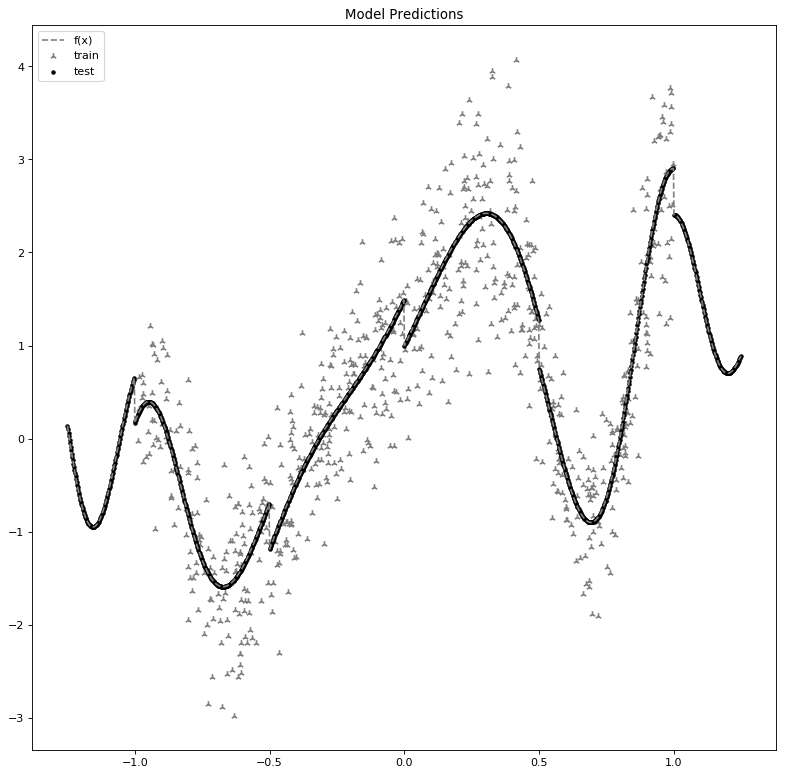

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=Full_Epochs,
                                                height=(N_Reconfigurations*Height_per_reconfig),
                                                depth=Initial_Depth,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Pre-trained benchmark model does not exist: Training.
Epoch 1/600
24/24 [==============================] - 2s 70ms/step - loss: 14.9729 - mse: 3544.3650 - mae: 14.9729 - mape: 2304.8638
Epoch 2/600
24/24 [==============================] - 1s 56ms/step - loss: 0.9263 - mse: 1.3826 - mae: 0.9263 - mape: 284.3251
Epoch 3/600
24/24 [==============================] - 1s 51ms/step - loss: 0.7325 - mse: 0.9058 - mae: 0.7325 - mape: 218.5449
Epoch 4/600
24/24 [==============================] - 1s 56ms/step - loss: 0.6360 - mse: 0.6199 - mae: 0.6360 - mape: 216.0692
Epoch 5/600
24/24 [==============================] - 1s 56ms/step - loss: 0.6467 - mse: 0.6689 - mae: 0.6467 - mape: 194.9091
Epoch 6/600
24/24 [==============================] - 2s 67ms/step - loss: 0.6546 - mse: 0.7005 - mae: 0.6546 - mape: 178.7988
Epoch 7/600
24/24 [==============================] - 2s 64ms/step - loss: 0.7564 - mse: 0.9350 - mae: 0.7564 - mape: 242.6525
Epoch 8/600
24/24 [==============================] - 1s 55

24/24 [==============================] - 1s 44ms/step - loss: 0.5512 - mse: 0.4802 - mae: 0.5512 - mape: 165.9776
Epoch 66/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5534 - mse: 0.4901 - mae: 0.5534 - mape: 182.7197
Epoch 67/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5164 - mse: 0.4368 - mae: 0.5164 - mape: 167.2614
Epoch 68/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5447 - mse: 0.4728 - mae: 0.5447 - mape: 197.9913
Epoch 69/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5350 - mse: 0.4545 - mae: 0.5350 - mape: 175.7747
Epoch 70/600
24/24 [==============================] - 1s 52ms/step - loss: 0.5356 - mse: 0.4718 - mae: 0.5356 - mape: 161.7153
Epoch 71/600
24/24 [==============================] - 1s 53ms/step - loss: 0.5443 - mse: 0.4847 - mae: 0.5443 - mape: 167.3639
Epoch 72/600
24/24 [==============================] - 1s 48ms/step - loss: 0.5659 - mse: 0.5200 - mae: 0.5659 - mape: 193.20

24/24 [==============================] - 2s 77ms/step - loss: 0.5365 - mse: 0.4498 - mae: 0.5365 - mape: 176.4465
Epoch 130/600
24/24 [==============================] - 2s 82ms/step - loss: 0.5290 - mse: 0.4439 - mae: 0.5290 - mape: 176.6520
Epoch 131/600
24/24 [==============================] - 2s 69ms/step - loss: 0.5155 - mse: 0.4233 - mae: 0.5155 - mape: 172.8165
Epoch 132/600
24/24 [==============================] - 2s 75ms/step - loss: 0.5291 - mse: 0.4568 - mae: 0.5291 - mape: 165.9021
Epoch 133/600
24/24 [==============================] - 2s 67ms/step - loss: 0.5438 - mse: 0.4754 - mae: 0.5438 - mape: 173.8486
Epoch 134/600
24/24 [==============================] - 1s 59ms/step - loss: 0.5324 - mse: 0.4534 - mae: 0.5324 - mape: 170.0185
Epoch 135/600
24/24 [==============================] - 1s 60ms/step - loss: 0.5245 - mse: 0.4323 - mae: 0.5245 - mape: 181.8850
Epoch 136/600
24/24 [==============================] - 1s 58ms/step - loss: 0.5236 - mse: 0.4290 - mae: 0.5236 - mape:

24/24 [==============================] - 1s 46ms/step - loss: 0.5230 - mse: 0.4430 - mae: 0.5230 - mape: 185.1252
Epoch 194/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5383 - mse: 0.4699 - mae: 0.5383 - mape: 173.3025
Epoch 195/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5305 - mse: 0.4456 - mae: 0.5305 - mape: 174.3666
Epoch 196/600
24/24 [==============================] - 1s 47ms/step - loss: 0.5216 - mse: 0.4354 - mae: 0.5216 - mape: 193.1221
Epoch 197/600
24/24 [==============================] - 1s 44ms/step - loss: 0.5207 - mse: 0.4328 - mae: 0.5207 - mape: 173.5994
Epoch 198/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5217 - mse: 0.4284 - mae: 0.5217 - mape: 167.7466
Epoch 199/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5334 - mse: 0.4639 - mae: 0.5334 - mape: 164.2988
Epoch 200/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5332 - mse: 0.4598 - mae: 0.5332 - mape:

24/24 [==============================] - 1s 46ms/step - loss: 0.5374 - mse: 0.4494 - mae: 0.5374 - mape: 182.7474
Epoch 257/600
24/24 [==============================] - 1s 44ms/step - loss: 0.5162 - mse: 0.4201 - mae: 0.5162 - mape: 181.5896
Epoch 258/600
24/24 [==============================] - 1s 49ms/step - loss: 0.5328 - mse: 0.4559 - mae: 0.5328 - mape: 186.5010
Epoch 259/600
24/24 [==============================] - 1s 57ms/step - loss: 0.5229 - mse: 0.4421 - mae: 0.5229 - mape: 171.0161
Epoch 260/600
24/24 [==============================] - 1s 55ms/step - loss: 0.5383 - mse: 0.4621 - mae: 0.5383 - mape: 187.0035
Epoch 261/600
24/24 [==============================] - 1s 54ms/step - loss: 0.5274 - mse: 0.4482 - mae: 0.5274 - mape: 186.9471
Epoch 262/600
24/24 [==============================] - 2s 70ms/step - loss: 0.5192 - mse: 0.4283 - mae: 0.5192 - mape: 177.7442
Epoch 263/600
24/24 [==============================] - 2s 69ms/step - loss: 0.5304 - mse: 0.4513 - mae: 0.5304 - mape:

24/24 [==============================] - 1s 46ms/step - loss: 0.5289 - mse: 0.4401 - mae: 0.5289 - mape: 178.1167
Epoch 321/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5528 - mse: 0.4852 - mae: 0.5528 - mape: 182.8353
Epoch 322/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5688 - mse: 0.5113 - mae: 0.5688 - mape: 179.8149
Epoch 323/600
24/24 [==============================] - 1s 60ms/step - loss: 0.5157 - mse: 0.4228 - mae: 0.5157 - mape: 170.5073
Epoch 324/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5264 - mse: 0.4401 - mae: 0.5264 - mape: 180.4951
Epoch 325/600
24/24 [==============================] - 1s 54ms/step - loss: 0.5340 - mse: 0.4568 - mae: 0.5340 - mape: 196.7519
Epoch 326/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5306 - mse: 0.4396 - mae: 0.5306 - mape: 176.7208
Epoch 327/600
24/24 [==============================] - 1s 54ms/step - loss: 0.5422 - mse: 0.4576 - mae: 0.5422 - mape:

24/24 [==============================] - 1s 47ms/step - loss: 0.5251 - mse: 0.4385 - mae: 0.5251 - mape: 182.9217
Epoch 384/600
24/24 [==============================] - 1s 47ms/step - loss: 0.5241 - mse: 0.4398 - mae: 0.5241 - mape: 181.9067
Epoch 385/600
24/24 [==============================] - 1s 47ms/step - loss: 0.5447 - mse: 0.4717 - mae: 0.5447 - mape: 165.3847
Epoch 386/600
24/24 [==============================] - 1s 47ms/step - loss: 0.5476 - mse: 0.4776 - mae: 0.5476 - mape: 161.8435
Epoch 387/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5260 - mse: 0.4393 - mae: 0.5260 - mape: 176.2638
Epoch 388/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5208 - mse: 0.4347 - mae: 0.5208 - mape: 164.3210
Epoch 389/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5189 - mse: 0.4347 - mae: 0.5189 - mape: 180.6079
Epoch 390/600
24/24 [==============================] - 1s 50ms/step - loss: 0.5322 - mse: 0.4722 - mae: 0.5322 - mape:

24/24 [==============================] - 1s 46ms/step - loss: 0.5099 - mse: 0.4216 - mae: 0.5099 - mape: 173.5093
Epoch 448/600
24/24 [==============================] - 1s 47ms/step - loss: 0.5112 - mse: 0.4084 - mae: 0.5112 - mape: 162.8929
Epoch 449/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5210 - mse: 0.4242 - mae: 0.5210 - mape: 184.7936
Epoch 450/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5092 - mse: 0.4072 - mae: 0.5092 - mape: 173.8058
Epoch 451/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5085 - mse: 0.4113 - mae: 0.5085 - mape: 165.0049
Epoch 452/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5244 - mse: 0.4296 - mae: 0.5244 - mape: 186.1628
Epoch 453/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5168 - mse: 0.4310 - mae: 0.5168 - mape: 169.3515
Epoch 454/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5229 - mse: 0.4294 - mae: 0.5229 - mape:

24/24 [==============================] - 1s 46ms/step - loss: 0.5196 - mse: 0.4300 - mae: 0.5196 - mape: 176.5241
Epoch 512/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5119 - mse: 0.4199 - mae: 0.5119 - mape: 176.8433
Epoch 513/600
24/24 [==============================] - 1s 53ms/step - loss: 0.5087 - mse: 0.4113 - mae: 0.5087 - mape: 163.8972
Epoch 514/600
24/24 [==============================] - 1s 44ms/step - loss: 0.5399 - mse: 0.4595 - mae: 0.5399 - mape: 187.5012
Epoch 515/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5190 - mse: 0.4277 - mae: 0.5190 - mape: 160.2797
Epoch 516/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5127 - mse: 0.4229 - mae: 0.5127 - mape: 172.5163
Epoch 517/600
24/24 [==============================] - 1s 47ms/step - loss: 0.5174 - mse: 0.4175 - mae: 0.5174 - mape: 186.8600
Epoch 518/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5258 - mse: 0.4417 - mae: 0.5258 - mape:

24/24 [==============================] - 1s 46ms/step - loss: 0.5091 - mse: 0.4076 - mae: 0.5091 - mape: 176.2658
Epoch 576/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5095 - mse: 0.4091 - mae: 0.5095 - mape: 173.8365
Epoch 577/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5172 - mse: 0.4203 - mae: 0.5172 - mape: 158.6626
Epoch 578/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5087 - mse: 0.4144 - mae: 0.5087 - mape: 171.0118
Epoch 579/600
24/24 [==============================] - 1s 45ms/step - loss: 0.5204 - mse: 0.4228 - mae: 0.5204 - mape: 178.1876
Epoch 580/600
24/24 [==============================] - 1s 46ms/step - loss: 0.5178 - mse: 0.4228 - mae: 0.5178 - mape: 170.3779
Epoch 581/600
24/24 [==============================] - 1s 53ms/step - loss: 0.5096 - mse: 0.4068 - mae: 0.5096 - mape: 170.8489
Epoch 582/600
24/24 [==============================] - 1s 47ms/step - loss: 0.5183 - mse: 0.4262 - mae: 0.5183 - mape:

## 1+2) Get base regression model for NEU + Learn optimal feature map

In [6]:
if os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=Full_Epochs, 
                                             height=Initial_Height, 
                                             depth=Initial_Depth,
                                             feature_map_depth=Feature_map_depth,
                                             feature_map_height=Feature_map_height,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/600
24/24 - 0s - loss: 0.5772 - mse: 0.8898 - mae: 0.5473 - mape: 94.4959
Epoch 2/600
24/24 - 0s - loss: 0.5155 - mse: 0.7495 - mae: 0.4895 - mape: 134.2608
Epoch 3/600
24/24 - 0s - loss: 0.4705 - mse: 0.6312 - mae: 0.4487 - mape: 148.9991
Epoch 4/600
24/24 - 0s - loss: 0.4645 - mse: 0.6110 - mae: 0.4434 - mape: 155.6178
Epoch 5/600
24/24 - 0s - loss: 0.4400 - mse: 0.5808 - mae: 0.4195 - mape: 131.6575
Epoch 6/600
24/24 - 0s - loss: 0.4350 - mse: 0.5655 - mae: 0.4149 - mape: 125.9997
Epoch 7/600
24/24 - 0s - loss: 0.4369 - mse: 0.5682 - mae: 0.4167 - mape: 127.3391
Epoch 8/600
24/24 - 0s - loss: 0.4312 - mse: 0.5547 - mae: 0.4116 - mape: 123.7972
Epoch 9/600
24/24 - 0s - loss: 0.4149 - mse: 0.5319 - mae: 0.3957 - mape: 130.4199
Epoch 10/600
24/24 - 0s - loss: 0.4153 - mse: 0.5152 - mae: 0.3970 - mape: 127.8196
Epoch 11/600
24/24 - 0s - loss: 0.3995 - mse: 0.4779 - mae: 0.3827 - mape: 114.3414
Epoch 12/600
24/24 - 0s - loss: 

Epoch 99/600
24/24 - 0s - loss: 0.2655 - mse: 0.2086 - mae: 0.2584 - mape: 86.3884
Epoch 100/600
24/24 - 0s - loss: 0.2658 - mse: 0.2090 - mae: 0.2587 - mape: 85.1796
Epoch 101/600
24/24 - 0s - loss: 0.2767 - mse: 0.2265 - mae: 0.2689 - mape: 93.0654
Epoch 102/600
24/24 - 0s - loss: 0.2670 - mse: 0.2159 - mae: 0.2595 - mape: 82.3969
Epoch 103/600
24/24 - 0s - loss: 0.2800 - mse: 0.2329 - mae: 0.2720 - mape: 94.8442
Epoch 104/600
24/24 - 0s - loss: 0.2838 - mse: 0.2401 - mae: 0.2756 - mape: 83.8534
Epoch 105/600
24/24 - 0s - loss: 0.2797 - mse: 0.2338 - mae: 0.2717 - mape: 84.3463
Epoch 106/600
24/24 - 0s - loss: 0.2709 - mse: 0.2198 - mae: 0.2633 - mape: 90.3879
Epoch 107/600
24/24 - 0s - loss: 0.2761 - mse: 0.2240 - mae: 0.2685 - mape: 95.5261
Epoch 108/600
24/24 - 0s - loss: 0.2716 - mse: 0.2236 - mae: 0.2639 - mape: 88.8900
Epoch 109/600
24/24 - 0s - loss: 0.2662 - mse: 0.2081 - mae: 0.2592 - mape: 90.5694
Epoch 110/600
24/24 - 0s - loss: 0.2644 - mse: 0.2103 - mae: 0.2571 - mape: 7

Epoch 197/600
24/24 - 0s - loss: 0.2682 - mse: 0.2174 - mae: 0.2607 - mape: 85.2996
Epoch 198/600
24/24 - 0s - loss: 0.2635 - mse: 0.2082 - mae: 0.2564 - mape: 93.9934
Epoch 199/600
24/24 - 0s - loss: 0.2706 - mse: 0.2232 - mae: 0.2628 - mape: 90.0121
Epoch 200/600
24/24 - 0s - loss: 0.2650 - mse: 0.2092 - mae: 0.2578 - mape: 88.5262
Epoch 201/600
24/24 - 0s - loss: 0.2738 - mse: 0.2268 - mae: 0.2659 - mape: 84.8321
Epoch 202/600
24/24 - 0s - loss: 0.2773 - mse: 0.2284 - mae: 0.2695 - mape: 91.8853
Epoch 203/600
24/24 - 0s - loss: 0.2605 - mse: 0.2038 - mae: 0.2535 - mape: 87.0304
Epoch 204/600
24/24 - 0s - loss: 0.2736 - mse: 0.2218 - mae: 0.2660 - mape: 92.7370
Epoch 205/600
24/24 - 0s - loss: 0.2701 - mse: 0.2168 - mae: 0.2627 - mape: 85.6222
Epoch 206/600
24/24 - 0s - loss: 0.2645 - mse: 0.2106 - mae: 0.2572 - mape: 87.4431
Epoch 207/600
24/24 - 0s - loss: 0.2809 - mse: 0.2353 - mae: 0.2728 - mape: 88.4062
Epoch 208/600
24/24 - 0s - loss: 0.2727 - mse: 0.2223 - mae: 0.2650 - mape: 

Epoch 295/600
24/24 - 0s - loss: 0.2711 - mse: 0.2212 - mae: 0.2635 - mape: 86.8748
Epoch 296/600
24/24 - 0s - loss: 0.2727 - mse: 0.2239 - mae: 0.2649 - mape: 91.1421
Epoch 297/600
24/24 - 0s - loss: 0.2609 - mse: 0.2059 - mae: 0.2537 - mape: 80.4317
Epoch 298/600
24/24 - 0s - loss: 0.2626 - mse: 0.2081 - mae: 0.2554 - mape: 82.2116
Epoch 299/600
24/24 - 0s - loss: 0.2652 - mse: 0.2106 - mae: 0.2579 - mape: 80.0076
Epoch 300/600
24/24 - 0s - loss: 0.2710 - mse: 0.2234 - mae: 0.2633 - mape: 85.2054
Epoch 301/600
24/24 - 0s - loss: 0.2598 - mse: 0.2026 - mae: 0.2528 - mape: 83.5125
Epoch 302/600
24/24 - 0s - loss: 0.2631 - mse: 0.2098 - mae: 0.2558 - mape: 83.2619
Epoch 303/600
24/24 - 0s - loss: 0.2648 - mse: 0.2132 - mae: 0.2574 - mape: 83.3631
Epoch 304/600
24/24 - 0s - loss: 0.2603 - mse: 0.2025 - mae: 0.2533 - mape: 85.0676
Epoch 305/600
24/24 - 0s - loss: 0.2739 - mse: 0.2204 - mae: 0.2664 - mape: 98.8459
Epoch 306/600
24/24 - 0s - loss: 0.2716 - mse: 0.2245 - mae: 0.2639 - mape: 

Epoch 393/600
24/24 - 0s - loss: 0.2782 - mse: 0.2267 - mae: 0.2705 - mape: 96.3729
Epoch 394/600
24/24 - 0s - loss: 0.2661 - mse: 0.2118 - mae: 0.2587 - mape: 90.4482
Epoch 395/600
24/24 - 0s - loss: 0.2658 - mse: 0.2147 - mae: 0.2584 - mape: 81.6269
Epoch 396/600
24/24 - 0s - loss: 0.2763 - mse: 0.2293 - mae: 0.2684 - mape: 83.4879
Epoch 397/600
24/24 - 0s - loss: 0.2693 - mse: 0.2182 - mae: 0.2617 - mape: 84.4873
Epoch 398/600
24/24 - 0s - loss: 0.2688 - mse: 0.2174 - mae: 0.2613 - mape: 86.1088
Epoch 399/600
24/24 - 0s - loss: 0.2646 - mse: 0.2096 - mae: 0.2574 - mape: 87.0567
Epoch 400/600
24/24 - 0s - loss: 0.2716 - mse: 0.2229 - mae: 0.2639 - mape: 91.3837
Epoch 401/600
24/24 - 0s - loss: 0.2764 - mse: 0.2327 - mae: 0.2683 - mape: 90.4708
Epoch 402/600
24/24 - 0s - loss: 0.2647 - mse: 0.2112 - mae: 0.2575 - mape: 82.5460
Epoch 403/600
24/24 - 0s - loss: 0.2677 - mse: 0.2142 - mae: 0.2603 - mape: 80.5537
Epoch 404/600
24/24 - 0s - loss: 0.2652 - mse: 0.2120 - mae: 0.2578 - mape: 

Epoch 491/600
24/24 - 0s - loss: 0.2713 - mse: 0.2159 - mae: 0.2640 - mape: 91.9134
Epoch 492/600
24/24 - 0s - loss: 0.2588 - mse: 0.2029 - mae: 0.2517 - mape: 82.8662
Epoch 493/600
24/24 - 0s - loss: 0.2629 - mse: 0.2112 - mae: 0.2555 - mape: 84.0395
Epoch 494/600
24/24 - 0s - loss: 0.2720 - mse: 0.2243 - mae: 0.2642 - mape: 87.7187
Epoch 495/600
24/24 - 0s - loss: 0.2669 - mse: 0.2140 - mae: 0.2595 - mape: 78.7121
Epoch 496/600
24/24 - 0s - loss: 0.2643 - mse: 0.2094 - mae: 0.2571 - mape: 86.6633
Epoch 497/600
24/24 - 0s - loss: 0.2681 - mse: 0.2134 - mae: 0.2608 - mape: 90.4951
Epoch 498/600
24/24 - 0s - loss: 0.2730 - mse: 0.2207 - mae: 0.2655 - mape: 95.5006
Epoch 499/600
24/24 - 0s - loss: 0.2611 - mse: 0.2063 - mae: 0.2540 - mape: 85.3355
Epoch 500/600
24/24 - 0s - loss: 0.2678 - mse: 0.2148 - mae: 0.2604 - mape: 86.5893
Epoch 501/600
24/24 - 0s - loss: 0.2606 - mse: 0.2024 - mae: 0.2536 - mape: 85.5945
Epoch 502/600
24/24 - 0s - loss: 0.2595 - mse: 0.2023 - mae: 0.2525 - mape: 

Epoch 589/600
24/24 - 0s - loss: 0.2618 - mse: 0.2085 - mae: 0.2545 - mape: 85.3059
Epoch 590/600
24/24 - 0s - loss: 0.2700 - mse: 0.2184 - mae: 0.2625 - mape: 87.8993
Epoch 591/600
24/24 - 0s - loss: 0.2707 - mse: 0.2188 - mae: 0.2632 - mape: 86.5057
Epoch 592/600
24/24 - 0s - loss: 0.2699 - mse: 0.2146 - mae: 0.2625 - mape: 90.7026
Epoch 593/600
24/24 - 0s - loss: 0.2712 - mse: 0.2202 - mae: 0.2636 - mape: 87.3828
Epoch 594/600
24/24 - 0s - loss: 0.2651 - mse: 0.2095 - mae: 0.2580 - mape: 82.4230
Epoch 595/600
24/24 - 0s - loss: 0.2656 - mse: 0.2108 - mae: 0.2583 - mape: 92.9474
Epoch 596/600
24/24 - 0s - loss: 0.2631 - mse: 0.2107 - mae: 0.2558 - mape: 93.7004
Epoch 597/600
24/24 - 0s - loss: 0.2641 - mse: 0.2110 - mae: 0.2568 - mape: 83.0162
Epoch 598/600
24/24 - 0s - loss: 0.2678 - mse: 0.2185 - mae: 0.2602 - mape: 83.8786
Epoch 599/600
24/24 - 0s - loss: 0.2706 - mse: 0.2199 - mae: 0.2630 - mape: 95.3777
Epoch 600/600
24/24 - 0s - loss: 0.2600 - mse: 0.2066 - mae: 0.2528 - mape: 

### Generate Plots - Visualization

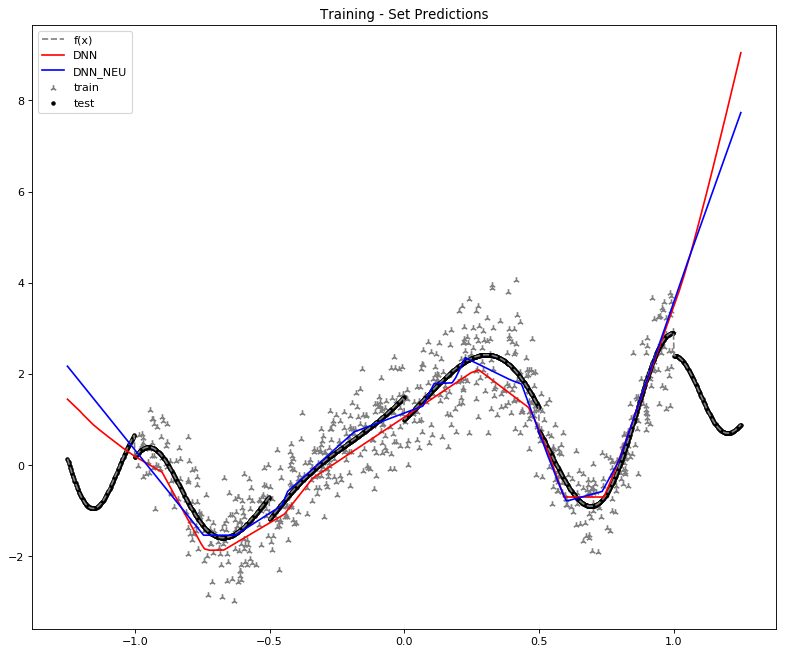

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='DNN')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [8]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
2.9983443282913855
0.01
4.480369669484457
0.02
3.6497455931178457
0.03
0.2614624946189443
0.04
1.5845842691169152
0.05
0.35694624424753146
0.06
1.0425411694027042
0.07
0.3571588838959639
0.08
0.316115776125334
0.09
0.6504929478204975
0.1
0.22028533098544897
0.11
0.5501383952236584
0.12
3.4128627199846653
0.13
0.3304919470191079
0.14
4.568109973735828
0.15
3.574302588053356
0.16
4.116363034542456
0.17
1.0672188078856955
0.18
1.1498785944665268
0.19
4.486175171491346
0.2
3.9417793548573035
0.21
3.291146995890386
0.22
5.067982932392394
0.23
1.0315352378269296
0.24
4.448837119999705
0.25
4.756610455281901
0.26
4.407632624241136
0.27
3.1768494844982773
0.28
4.475029688803864
0.29
2.0892460676935474
0.3
1.1776718038150589
0.31
4.9715028400938115
0.32
1.0113157741895666
0.33
5.092521572497404
0.34
3.84022278014874
0.35
4.244921525186596
0.36
4.914131419566873
0.37
4.867975243523318
0.38
2.2300267819992277
0.39
0.5165211716073476
0.4
1.27832995296550

24/24 [==============================] - 2s 78ms/step - loss: 0.5170 - mse: 0.4190 - mae: 0.5092
Epoch 52/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5043 - mse: 0.3963 - mae: 0.4970
Epoch 53/600
24/24 [==============================] - 2s 80ms/step - loss: 0.5138 - mse: 0.4048 - mae: 0.5067
Epoch 54/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5130 - mse: 0.4056 - mae: 0.5056
Epoch 55/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5059 - mse: 0.4000 - mae: 0.4986
Epoch 56/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5069 - mse: 0.4003 - mae: 0.4995
Epoch 57/600
24/24 [==============================] - 2s 76ms/step - loss: 0.5062 - mse: 0.4007 - mae: 0.4987
Epoch 58/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5146 - mse: 0.4120 - mae: 0.5070
Epoch 59/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5042 - mse: 0.3910 - mae: 0.4971
Epoch 60/600
24/24 [===

24/24 [==============================] - 2s 78ms/step - loss: 0.5074 - mse: 0.4034 - mae: 0.5001
Epoch 126/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5050 - mse: 0.3943 - mae: 0.4978
Epoch 127/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5116 - mse: 0.4011 - mae: 0.5043
Epoch 128/600
24/24 [==============================] - 2s 80ms/step - loss: 0.5055 - mse: 0.3968 - mae: 0.4982
Epoch 129/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5076 - mse: 0.4004 - mae: 0.5002
Epoch 130/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5097 - mse: 0.3964 - mae: 0.5027
Epoch 131/600
24/24 [==============================] - 2s 80ms/step - loss: 0.5040 - mse: 0.3949 - mae: 0.4968
Epoch 132/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5025 - mse: 0.3975 - mae: 0.4950
Epoch 133/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5126 - mse: 0.4014 - mae: 0.5054
Epoch 134/600
2

24/24 [==============================] - 2s 78ms/step - loss: 0.5047 - mse: 0.3965 - mae: 0.4974
Epoch 199/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5014 - mse: 0.3919 - mae: 0.4941
Epoch 200/600
24/24 [==============================] - 2s 81ms/step - loss: 0.5045 - mse: 0.3972 - mae: 0.4971
Epoch 201/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5068 - mse: 0.3954 - mae: 0.4997
Epoch 202/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5016 - mse: 0.3948 - mae: 0.4942
Epoch 203/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5127 - mse: 0.4065 - mae: 0.5052
Epoch 204/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5074 - mse: 0.3953 - mae: 0.5003
Epoch 205/600
24/24 [==============================] - 2s 81ms/step - loss: 0.5004 - mse: 0.3898 - mae: 0.4932
Epoch 206/600
24/24 [==============================] - 2s 80ms/step - loss: 0.5016 - mse: 0.3903 - mae: 0.4944
Epoch 207/600
2

24/24 [==============================] - 2s 84ms/step - loss: 0.5042 - mse: 0.3953 - mae: 0.4970
Epoch 272/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5047 - mse: 0.3955 - mae: 0.4975
Epoch 273/600
24/24 [==============================] - 2s 80ms/step - loss: 0.5010 - mse: 0.3894 - mae: 0.4939
Epoch 274/600
24/24 [==============================] - 2s 86ms/step - loss: 0.5031 - mse: 0.3913 - mae: 0.4960
Epoch 275/600
24/24 [==============================] - 2s 92ms/step - loss: 0.5007 - mse: 0.3912 - mae: 0.4935
Epoch 276/600
24/24 [==============================] - 2s 87ms/step - loss: 0.5052 - mse: 0.3965 - mae: 0.4979
Epoch 277/600
24/24 [==============================] - 2s 87ms/step - loss: 0.5044 - mse: 0.3939 - mae: 0.4974
Epoch 278/600
24/24 [==============================] - 2s 91ms/step - loss: 0.5002 - mse: 0.3914 - mae: 0.4929
Epoch 279/600
24/24 [==============================] - 2s 94ms/step - loss: 0.5079 - mse: 0.3959 - mae: 0.5007
Epoch 280/600
2

24/24 [==============================] - 2s 83ms/step - loss: 0.5034 - mse: 0.3948 - mae: 0.4961
Epoch 345/600
24/24 [==============================] - 2s 95ms/step - loss: 0.5022 - mse: 0.3908 - mae: 0.4953
Epoch 346/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5022 - mse: 0.3942 - mae: 0.4949
Epoch 347/600
24/24 [==============================] - 2s 86ms/step - loss: 0.5029 - mse: 0.3929 - mae: 0.4958
Epoch 348/600
24/24 [==============================] - 2s 84ms/step - loss: 0.5024 - mse: 0.3921 - mae: 0.4953
Epoch 349/600
24/24 [==============================] - 2s 88ms/step - loss: 0.5012 - mse: 0.3896 - mae: 0.4940
Epoch 350/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5022 - mse: 0.3916 - mae: 0.4950
Epoch 351/600
24/24 [==============================] - 2s 88ms/step - loss: 0.5108 - mse: 0.4015 - mae: 0.5035
Epoch 352/600
24/24 [==============================] - 2s 86ms/step - loss: 0.5031 - mse: 0.3925 - mae: 0.4959
Epoch 353/600
2

24/24 [==============================] - 2s 76ms/step - loss: 0.5005 - mse: 0.3878 - mae: 0.4936
Epoch 418/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5013 - mse: 0.3899 - mae: 0.4942
Epoch 419/600
24/24 [==============================] - 2s 80ms/step - loss: 0.5012 - mse: 0.3910 - mae: 0.4940
Epoch 420/600
24/24 [==============================] - 2s 77ms/step - loss: 0.4996 - mse: 0.3886 - mae: 0.4925
Epoch 421/600
24/24 [==============================] - 2s 76ms/step - loss: 0.5095 - mse: 0.4041 - mae: 0.5021
Epoch 422/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5047 - mse: 0.3936 - mae: 0.4976
Epoch 423/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5027 - mse: 0.3943 - mae: 0.4953
Epoch 424/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5079 - mse: 0.3995 - mae: 0.5006
Epoch 425/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5009 - mse: 0.3883 - mae: 0.4939
Epoch 426/600
2

24/24 [==============================] - 2s 83ms/step - loss: 0.5161 - mse: 0.4073 - mae: 0.5089
Epoch 491/600
24/24 [==============================] - 2s 79ms/step - loss: 0.5001 - mse: 0.3887 - mae: 0.4932
Epoch 492/600
24/24 [==============================] - 2s 87ms/step - loss: 0.5016 - mse: 0.3919 - mae: 0.4944
Epoch 493/600
24/24 [==============================] - 2s 77ms/step - loss: 0.4975 - mse: 0.3869 - mae: 0.4903
Epoch 494/600
24/24 [==============================] - 2s 77ms/step - loss: 0.4994 - mse: 0.3848 - mae: 0.4924
Epoch 495/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5039 - mse: 0.3902 - mae: 0.4968
Epoch 496/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5028 - mse: 0.3910 - mae: 0.4956
Epoch 497/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5005 - mse: 0.3898 - mae: 0.4936
Epoch 498/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5015 - mse: 0.3903 - mae: 0.4945
Epoch 499/600
2

24/24 [==============================] - 2s 77ms/step - loss: 0.5007 - mse: 0.3926 - mae: 0.4935
Epoch 564/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5039 - mse: 0.3884 - mae: 0.4970
Epoch 565/600
24/24 [==============================] - 2s 77ms/step - loss: 0.5007 - mse: 0.3891 - mae: 0.4935
Epoch 566/600
24/24 [==============================] - 2s 80ms/step - loss: 0.5032 - mse: 0.3939 - mae: 0.4961
Epoch 567/600
24/24 [==============================] - 2s 78ms/step - loss: 0.5041 - mse: 0.3948 - mae: 0.4968
Epoch 568/600
24/24 [==============================] - 2s 87ms/step - loss: 0.5032 - mse: 0.3931 - mae: 0.4960
Epoch 569/600
24/24 [==============================] - 2s 81ms/step - loss: 0.5046 - mse: 0.3956 - mae: 0.4973
Epoch 570/600
24/24 [==============================] - 2s 84ms/step - loss: 0.4984 - mse: 0.3889 - mae: 0.4912
Epoch 571/600
24/24 [==============================] - 2s 76ms/step - loss: 0.5024 - mse: 0.3889 - mae: 0.4954
Epoch 572/600
2

### Generate Plots - Visualization

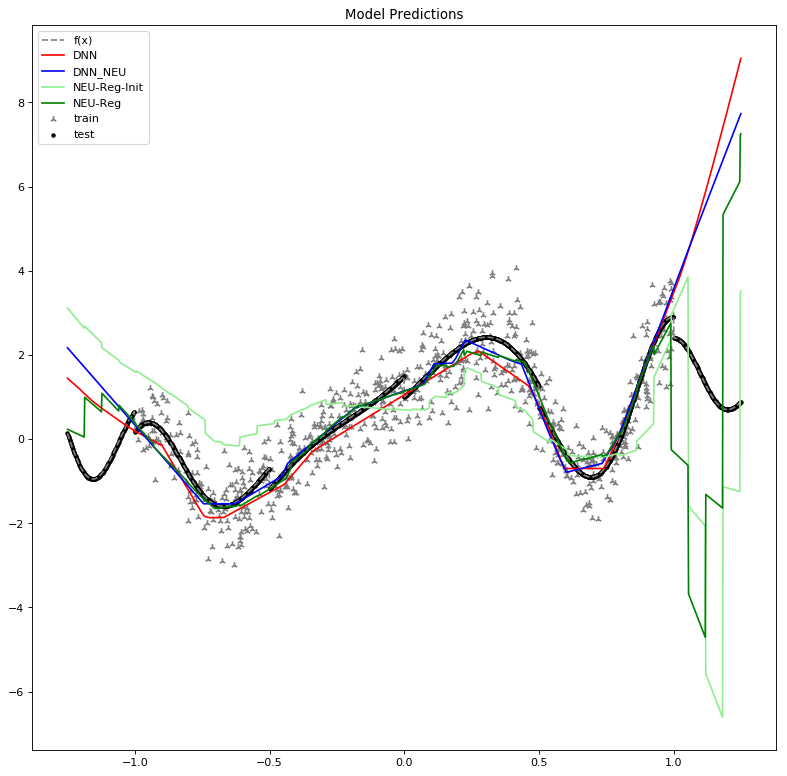

In [9]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

---
---
---

# Benchmark Models

In [10]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

GLd-Nets Model does not exist: Training.
Epoch 1/200
24/24 - 0s - loss: 0.5860 - mse: 1.0423 - mae: 0.5860 - mape: 83.3133
Epoch 2/200
24/24 - 0s - loss: 0.5756 - mse: 0.9947 - mae: 0.5756 - mape: 85.5941
Epoch 3/200
24/24 - 0s - loss: 0.5779 - mse: 0.9996 - mae: 0.5779 - mape: 96.6303
Epoch 4/200
24/24 - 0s - loss: 0.5772 - mse: 0.9939 - mae: 0.5772 - mape: 87.8122
Epoch 5/200
24/24 - 0s - loss: 0.5765 - mse: 0.9996 - mae: 0.5765 - mape: 85.3714
Epoch 6/200
24/24 - 0s - loss: 0.5761 - mse: 0.9902 - mae: 0.5761 - mape: 94.7848
Epoch 7/200
24/24 - 0s - loss: 0.5754 - mse: 0.9916 - mae: 0.5754 - mape: 90.5257
Epoch 8/200
24/24 - 0s - loss: 0.5765 - mse: 0.9924 - mae: 0.5765 - mape: 86.7320
Epoch 9/200
24/24 - 0s - loss: 0.5773 - mse: 0.9983 - mae: 0.5773 - mape: 93.9646
Epoch 10/200
24/24 - 0s - loss: 0.5758 - mse: 0.9869 - mae: 0.5758 - mape: 95.3769
Epoch 11/200
24/24 - 0s - loss: 0.5778 - mse: 1.0113 - mae: 0.5778 - mape: 86.1417
Epoch 12/200
24/24 - 0s - loss: 0.5793 - mse: 0.9919 - 

Epoch 100/200
24/24 - 0s - loss: 0.5746 - mse: 0.9901 - mae: 0.5746 - mape: 89.6385
Epoch 101/200
24/24 - 0s - loss: 0.5746 - mse: 0.9889 - mae: 0.5746 - mape: 91.1334
Epoch 102/200
24/24 - 0s - loss: 0.5746 - mse: 0.9897 - mae: 0.5746 - mape: 89.8396
Epoch 103/200
24/24 - 0s - loss: 0.5746 - mse: 0.9893 - mae: 0.5746 - mape: 91.0528
Epoch 104/200
24/24 - 0s - loss: 0.5745 - mse: 0.9887 - mae: 0.5745 - mape: 91.2652
Epoch 105/200
24/24 - 0s - loss: 0.5748 - mse: 0.9906 - mae: 0.5748 - mape: 89.2057
Epoch 106/200
24/24 - 0s - loss: 0.5748 - mse: 0.9898 - mae: 0.5748 - mape: 90.4696
Epoch 107/200
24/24 - 0s - loss: 0.5745 - mse: 0.9894 - mae: 0.5745 - mape: 89.8188
Epoch 108/200
24/24 - 0s - loss: 0.5745 - mse: 0.9897 - mae: 0.5745 - mape: 89.7844
Epoch 109/200
24/24 - 0s - loss: 0.5748 - mse: 0.9914 - mae: 0.5748 - mape: 88.7067
Epoch 110/200
24/24 - 0s - loss: 0.5745 - mse: 0.9893 - mae: 0.5745 - mape: 90.7521
Epoch 111/200
24/24 - 0s - loss: 0.5746 - mse: 0.9877 - mae: 0.5746 - mape: 

Epoch 198/200
24/24 - 0s - loss: 0.5746 - mse: 0.9892 - mae: 0.5746 - mape: 91.1640
Epoch 199/200
24/24 - 0s - loss: 0.5747 - mse: 0.9923 - mae: 0.5747 - mape: 86.4600
Epoch 200/200
24/24 - 0s - loss: 0.5754 - mse: 0.9897 - mae: 0.5754 - mape: 92.1506
Epoch 1/600
24/24 [==============================] - 0s 5ms/step - loss: 1.9578 - mse: 1.9578 - mae: 1.1552
Epoch 2/600
24/24 [==============================] - 0s 5ms/step - loss: 1.9527 - mse: 1.9527 - mae: 1.1538
Epoch 3/600
24/24 [==============================] - 0s 5ms/step - loss: 1.9479 - mse: 1.9479 - mae: 1.1525
Epoch 4/600
24/24 [==============================] - 0s 6ms/step - loss: 1.9435 - mse: 1.9435 - mae: 1.1511
Epoch 5/600
24/24 [==============================] - 0s 6ms/step - loss: 1.9393 - mse: 1.9393 - mae: 1.1499
Epoch 6/600
24/24 [==============================] - 0s 6ms/step - loss: 1.9354 - mse: 1.9354 - mae: 1.1489
Epoch 7/600
24/24 [==============================] - 0s 6ms/step - loss: 1.9319 - mse: 1.9319 - mae:

24/24 [==============================] - 0s 3ms/step - loss: 1.8551 - mse: 1.8551 - mae: 1.1248
Epoch 74/600
24/24 [==============================] - 0s 3ms/step - loss: 1.8546 - mse: 1.8546 - mae: 1.1247
Epoch 75/600
24/24 [==============================] - 0s 5ms/step - loss: 1.8541 - mse: 1.8541 - mae: 1.1245
Epoch 76/600
24/24 [==============================] - 0s 5ms/step - loss: 1.8535 - mse: 1.8535 - mae: 1.1243
Epoch 77/600
24/24 [==============================] - 0s 6ms/step - loss: 1.8530 - mse: 1.8530 - mae: 1.1242
Epoch 78/600
24/24 [==============================] - 0s 6ms/step - loss: 1.8525 - mse: 1.8525 - mae: 1.1240
Epoch 79/600
24/24 [==============================] - 0s 3ms/step - loss: 1.8520 - mse: 1.8520 - mae: 1.1239
Epoch 80/600
24/24 [==============================] - 0s 4ms/step - loss: 1.8515 - mse: 1.8515 - mae: 1.1237
Epoch 81/600
24/24 [==============================] - 0s 3ms/step - loss: 1.8510 - mse: 1.8510 - mae: 1.1236
Epoch 82/600
24/24 [============

24/24 [==============================] - 0s 6ms/step - loss: 1.8246 - mse: 1.8246 - mae: 1.1162
Epoch 148/600
24/24 [==============================] - 0s 6ms/step - loss: 1.8242 - mse: 1.8242 - mae: 1.1161
Epoch 149/600
24/24 [==============================] - 0s 5ms/step - loss: 1.8239 - mse: 1.8239 - mae: 1.1160
Epoch 150/600
24/24 [==============================] - 0s 6ms/step - loss: 1.8236 - mse: 1.8236 - mae: 1.1159
Epoch 151/600
24/24 [==============================] - 0s 5ms/step - loss: 1.8232 - mse: 1.8232 - mae: 1.1158
Epoch 152/600
24/24 [==============================] - 0s 6ms/step - loss: 1.8229 - mse: 1.8229 - mae: 1.1157
Epoch 153/600
24/24 [==============================] - 0s 6ms/step - loss: 1.8226 - mse: 1.8226 - mae: 1.1156
Epoch 154/600
24/24 [==============================] - 0s 6ms/step - loss: 1.8222 - mse: 1.8222 - mae: 1.1155
Epoch 155/600
24/24 [==============================] - 0s 4ms/step - loss: 1.8219 - mse: 1.8219 - mae: 1.1154
Epoch 156/600
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 1.8029 - mse: 1.8029 - mae: 1.1100
Epoch 222/600
24/24 [==============================] - 0s 4ms/step - loss: 1.8027 - mse: 1.8027 - mae: 1.1099
Epoch 223/600
24/24 [==============================] - 0s 5ms/step - loss: 1.8024 - mse: 1.8024 - mae: 1.1099
Epoch 224/600
24/24 [==============================] - 0s 4ms/step - loss: 1.8022 - mse: 1.8022 - mae: 1.1098
Epoch 225/600
24/24 [==============================] - 0s 4ms/step - loss: 1.8019 - mse: 1.8019 - mae: 1.1097
Epoch 226/600
24/24 [==============================] - 0s 3ms/step - loss: 1.8017 - mse: 1.8017 - mae: 1.1096
Epoch 227/600
24/24 [==============================] - 0s 4ms/step - loss: 1.8015 - mse: 1.8015 - mae: 1.1096
Epoch 228/600
24/24 [==============================] - 0s 3ms/step - loss: 1.8012 - mse: 1.8012 - mae: 1.1095
Epoch 229/600
24/24 [==============================] - 0s 3ms/step - loss: 1.8010 - mse: 1.8010 - mae: 1.1094
Epoch 230/600
24/24 [===

24/24 [==============================] - 0s 4ms/step - loss: 1.7873 - mse: 1.7873 - mae: 1.1055
Epoch 296/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7872 - mse: 1.7872 - mae: 1.1054
Epoch 297/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7870 - mse: 1.7870 - mae: 1.1054
Epoch 298/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7868 - mse: 1.7868 - mae: 1.1053
Epoch 299/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7867 - mse: 1.7867 - mae: 1.1053
Epoch 300/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7865 - mse: 1.7865 - mae: 1.1052
Epoch 301/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7863 - mse: 1.7863 - mae: 1.1052
Epoch 302/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7861 - mse: 1.7861 - mae: 1.1051
Epoch 303/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7860 - mse: 1.7860 - mae: 1.1051
Epoch 304/600
24/24 [===

24/24 [==============================] - 0s 4ms/step - loss: 1.7762 - mse: 1.7762 - mae: 1.1023
Epoch 370/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7761 - mse: 1.7761 - mae: 1.1023
Epoch 371/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7759 - mse: 1.7759 - mae: 1.1023
Epoch 372/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7758 - mse: 1.7758 - mae: 1.1022
Epoch 373/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7757 - mse: 1.7757 - mae: 1.1022
Epoch 374/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7755 - mse: 1.7755 - mae: 1.1021
Epoch 375/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7754 - mse: 1.7754 - mae: 1.1021
Epoch 376/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7753 - mse: 1.7753 - mae: 1.1021
Epoch 377/600
24/24 [==============================] - 0s 7ms/step - loss: 1.7752 - mse: 1.7752 - mae: 1.1020
Epoch 378/600
24/24 [===

24/24 [==============================] - 0s 5ms/step - loss: 1.7682 - mse: 1.7682 - mae: 1.1002
Epoch 444/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7681 - mse: 1.7681 - mae: 1.1002
Epoch 445/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7681 - mse: 1.7681 - mae: 1.1001
Epoch 446/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7679 - mse: 1.7679 - mae: 1.1001
Epoch 447/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7679 - mse: 1.7679 - mae: 1.1001
Epoch 448/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7677 - mse: 1.7677 - mae: 1.1000
Epoch 449/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7676 - mse: 1.7676 - mae: 1.1000
Epoch 450/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7676 - mse: 1.7676 - mae: 1.1000
Epoch 451/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7675 - mse: 1.7675 - mae: 1.1000
Epoch 452/600
24/24 [===

24/24 [==============================] - 0s 4ms/step - loss: 1.7625 - mse: 1.7625 - mae: 1.0987
Epoch 518/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7624 - mse: 1.7624 - mae: 1.0987
Epoch 519/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7623 - mse: 1.7623 - mae: 1.0987
Epoch 520/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7623 - mse: 1.7623 - mae: 1.0987
Epoch 521/600
24/24 [==============================] - 0s 7ms/step - loss: 1.7622 - mse: 1.7622 - mae: 1.0987
Epoch 522/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7621 - mse: 1.7621 - mae: 1.0987
Epoch 523/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7621 - mse: 1.7621 - mae: 1.0986
Epoch 524/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7620 - mse: 1.7620 - mae: 1.0986
Epoch 525/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7620 - mse: 1.7620 - mae: 1.0986
Epoch 526/600
24/24 [===

24/24 [==============================] - 0s 4ms/step - loss: 1.7582 - mse: 1.7582 - mae: 1.0977
Epoch 592/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7581 - mse: 1.7581 - mae: 1.0977
Epoch 593/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7581 - mse: 1.7581 - mae: 1.0976
Epoch 594/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7581 - mse: 1.7581 - mae: 1.0976
Epoch 595/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7580 - mse: 1.7580 - mae: 1.0976
Epoch 596/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7579 - mse: 1.7579 - mae: 1.0976
Epoch 597/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7579 - mse: 1.7579 - mae: 1.0976
Epoch 598/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7579 - mse: 1.7579 - mae: 1.0976
Epoch 599/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7578 - mse: 1.7578 - mae: 1.0976
Epoch 600/600
24/24 [===

In [11]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Ed-Nets Model does not exist: Training.
Epoch 1/600
24/24 [==============================] - 0s 2ms/step - loss: 4.1262 - mse: 4.1262 - mae: 1.6527
Epoch 2/600
24/24 [==============================] - 0s 2ms/step - loss: 3.2685 - mse: 3.2685 - mae: 1.4816
Epoch 3/600
24/24 [==============================] - 0s 2ms/step - loss: 2.9720 - mse: 2.9720 - mae: 1.4126
Epoch 4/600
24/24 [==============================] - 0s 2ms/step - loss: 2.8132 - mse: 2.8132 - mae: 1.3722
Epoch 5/600
24/24 [==============================] - 0s 2ms/step - loss: 2.7125 - mse: 2.7125 - mae: 1.3450
Epoch 6/600
24/24 [==============================] - 0s 3ms/step - loss: 2.6418 - mse: 2.6418 - mae: 1.3263
Epoch 7/600
24/24 [==============================] - 0s 2ms/step - loss: 2.5889 - mse: 2.5889 - mae: 1.3113
Epoch 8/600
24/24 [==============================] - 0s 3ms/step - loss: 2.5471 - mse: 2.5471 - mae: 1.2995
Epoch 9/600
24/24 [==============================] - 0s 3ms/step - loss: 2.5118 - mse: 2.5118 - 

24/24 [==============================] - 0s 4ms/step - loss: 1.9431 - mse: 1.9431 - mae: 1.1451
Epoch 76/600
24/24 [==============================] - 0s 4ms/step - loss: 1.9392 - mse: 1.9392 - mae: 1.1443
Epoch 77/600
24/24 [==============================] - 0s 5ms/step - loss: 1.9357 - mse: 1.9357 - mae: 1.1434
Epoch 78/600
24/24 [==============================] - 0s 4ms/step - loss: 1.9321 - mse: 1.9321 - mae: 1.1425
Epoch 79/600
24/24 [==============================] - 0s 3ms/step - loss: 1.9287 - mse: 1.9287 - mae: 1.1418
Epoch 80/600
24/24 [==============================] - 0s 4ms/step - loss: 1.9253 - mse: 1.9253 - mae: 1.1409
Epoch 81/600
24/24 [==============================] - 0s 4ms/step - loss: 1.9219 - mse: 1.9219 - mae: 1.1400
Epoch 82/600
24/24 [==============================] - 0s 3ms/step - loss: 1.9185 - mse: 1.9185 - mae: 1.1392
Epoch 83/600
24/24 [==============================] - 0s 3ms/step - loss: 1.9154 - mse: 1.9154 - mae: 1.1385
Epoch 84/600
24/24 [============

24/24 [==============================] - 0s 4ms/step - loss: 1.7775 - mse: 1.7775 - mae: 1.1024
Epoch 150/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7761 - mse: 1.7761 - mae: 1.1020
Epoch 151/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7747 - mse: 1.7747 - mae: 1.1016
Epoch 152/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7735 - mse: 1.7735 - mae: 1.1013
Epoch 153/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7722 - mse: 1.7722 - mae: 1.1009
Epoch 154/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7709 - mse: 1.7709 - mae: 1.1006
Epoch 155/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7696 - mse: 1.7696 - mae: 1.1002
Epoch 156/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7684 - mse: 1.7684 - mae: 1.0999
Epoch 157/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7672 - mse: 1.7672 - mae: 1.0996
Epoch 158/600
24/24 [===

24/24 [==============================] - 0s 4ms/step - loss: 1.7183 - mse: 1.7183 - mae: 1.0869
Epoch 224/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7180 - mse: 1.7180 - mae: 1.0868
Epoch 225/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7177 - mse: 1.7177 - mae: 1.0867
Epoch 226/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7173 - mse: 1.7173 - mae: 1.0867
Epoch 227/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7170 - mse: 1.7170 - mae: 1.0866
Epoch 228/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7167 - mse: 1.7167 - mae: 1.0865
Epoch 229/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7163 - mse: 1.7163 - mae: 1.0864
Epoch 230/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7161 - mse: 1.7161 - mae: 1.0864
Epoch 231/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7157 - mse: 1.7157 - mae: 1.0863
Epoch 232/600
24/24 [===

24/24 [==============================] - 0s 5ms/step - loss: 1.7112 - mse: 1.7112 - mae: 1.0851
Epoch 298/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7112 - mse: 1.7112 - mae: 1.0852
Epoch 299/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7112 - mse: 1.7112 - mae: 1.0852
Epoch 300/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7112 - mse: 1.7112 - mae: 1.0851
Epoch 301/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7111 - mse: 1.7111 - mae: 1.0851
Epoch 302/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7111 - mse: 1.7111 - mae: 1.0851
Epoch 303/600
24/24 [==============================] - 0s 6ms/step - loss: 1.7111 - mse: 1.7111 - mae: 1.0852
Epoch 304/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7111 - mse: 1.7111 - mae: 1.0851
Epoch 305/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7111 - mse: 1.7111 - mae: 1.0851
Epoch 306/600
24/24 [===

24/24 [==============================] - 0s 4ms/step - loss: 1.7092 - mse: 1.7092 - mae: 1.0847
Epoch 372/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7092 - mse: 1.7092 - mae: 1.0847
Epoch 373/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7092 - mse: 1.7092 - mae: 1.0847
Epoch 374/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7091 - mse: 1.7091 - mae: 1.0847
Epoch 375/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7091 - mse: 1.7091 - mae: 1.0847
Epoch 376/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7091 - mse: 1.7091 - mae: 1.0847
Epoch 377/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7090 - mse: 1.7090 - mae: 1.0847
Epoch 378/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7090 - mse: 1.7090 - mae: 1.0847
Epoch 379/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7090 - mse: 1.7090 - mae: 1.0846
Epoch 380/600
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 1.7077 - mse: 1.7077 - mae: 1.0844
Epoch 446/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7076 - mse: 1.7076 - mae: 1.0844
Epoch 447/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7076 - mse: 1.7076 - mae: 1.0844
Epoch 448/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7075 - mse: 1.7075 - mae: 1.0843
Epoch 449/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7075 - mse: 1.7075 - mae: 1.0843
Epoch 450/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7075 - mse: 1.7075 - mae: 1.0844
Epoch 451/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7075 - mse: 1.7075 - mae: 1.0843
Epoch 452/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7075 - mse: 1.7075 - mae: 1.0843
Epoch 453/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7075 - mse: 1.7075 - mae: 1.0843
Epoch 454/600
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0842
Epoch 520/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7069 - mse: 1.7069 - mae: 1.0843
Epoch 521/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0843
Epoch 522/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0843
Epoch 523/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0843
Epoch 524/600
24/24 [==============================] - 0s 3ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0843
Epoch 525/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0843
Epoch 526/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0843
Epoch 527/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7068 - mse: 1.7068 - mae: 1.0843
Epoch 528/600
24/24 [===

24/24 [==============================] - 0s 5ms/step - loss: 1.7065 - mse: 1.7065 - mae: 1.0843
Epoch 594/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7065 - mse: 1.7065 - mae: 1.0843
Epoch 595/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7065 - mse: 1.7065 - mae: 1.0843
Epoch 596/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7065 - mse: 1.7065 - mae: 1.0843
Epoch 597/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7065 - mse: 1.7065 - mae: 1.0843
Epoch 598/600
24/24 [==============================] - 0s 5ms/step - loss: 1.7065 - mse: 1.7065 - mae: 1.0843
Epoch 599/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7065 - mse: 1.7065 - mae: 1.0843
Epoch 600/600
24/24 [==============================] - 0s 4ms/step - loss: 1.7066 - mse: 1.7066 - mae: 1.0843
Ed-Nets Model: Saving
INFO:tensorflow:Assets written to: ./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/assets
Ed-Nets Model: 

Run univariate regression benchmarks file:

In [12]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [13]:
# Train Set #
#-----------#
Vanilla = get_results(predictions_OLS_Benchmark,data_y)
NEU = get_results(NEU_OLS_prediction,data_y)
NEU_Gld = get_results(Deep_GLd_prediction,data_y)
NEU_Ed = get_results(Deep_Ed_prediction,data_y)
SSplines = get_results(f_hat_smoothing_splines_train,data_y)
LOESS = get_results(LOESS_prediction_train,data_y)

# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results = pd.DataFrame.transpose(Results)

# Write Results to file #
#-----------------------#
Results.to_latex('./outputs/results/Performance.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results))

Test results.

In [14]:
# Test Set #
#----------#
Vanilla = get_results(predictions_OLS_Benchmark_test,data_y_test)
NEU = get_results(NEU_OLS_prediction_test,data_y_test)
NEU_Gld = get_results(Deep_GLd_prediction_test,data_y_test)
NEU_Ed = get_results(Deep_Ed_prediction_test,data_y_test)
SSplines = get_results(f_hat_smoothing_splines_test,data_y_test)
LOESS = get_results(LOESS_prediction_test,data_y_test)

# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results_test = pd.DataFrame.transpose(Results_test)

# Write Results to file #
#-----------------------#
Results_test.to_latex('./outputs/results/Performance_test.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_test_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results_test))

# Visualize Predictions

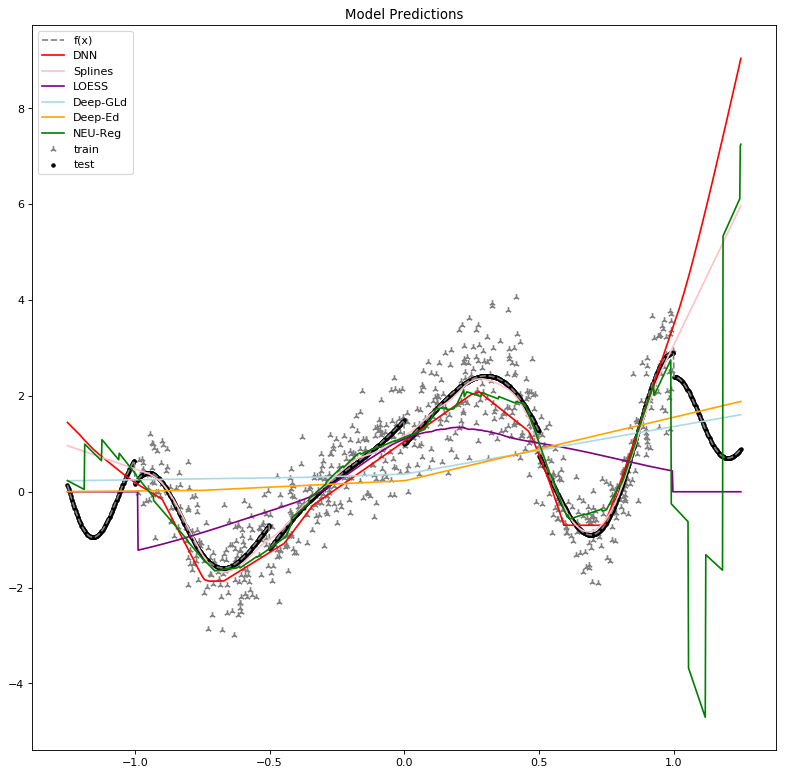

In [15]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
#------------------#
# Standard Benchmarks
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')
# Plot Univariate Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# NEU Benchmarks: Alternatives to reconfigurations
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')

# Plot NEU Regressors
# ---------------------------------- for INDEV  only: BEGIN --------------------------------------------------- #
# plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
# plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
# ---------------------------------- for INDEV  only: END ----------------------------------------------------- #
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

# Report Results

In [16]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Train Results:


,MSE,MaxE,MAE,MinE,rMSE
Vanilla,0.532036,0.002158,2.589987,0.452416,0.536301
NEU,0.508436,0.000027,2.186912,0.411433,0.512284
NEU_GLd,1.097533,0.002702,3.285145,1.757662,1.111452
NEU_Ed,1.084260,0.001940,3.286564,1.706416,1.097617
Smoothing_Splines,0.493159,0.000781,2.081169,0.374035,0.496449
LOESS,0.877084,0.004816,3.319869,1.223406,0.888567


In [17]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Test Results:


,MSE,MaxE,MAE,MinE,rMSE
Vanilla,0.810365,0.000113,8.155992,2.994676,0.873977
NEU,0.673363,0.000067,6.363470,2.136720,0.718209
NEU_GLd,0.959540,0.000293,1.959113,1.240679,0.967539
NEU_Ed,0.942216,0.000090,2.053291,1.191877,0.949827
Smoothing_Splines,0.491288,0.000179,5.083055,1.354980,0.520622
LOESS,0.787506,0.001151,2.903337,0.972904,0.796398


#### The END

---